In [97]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [98]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [99]:
# Get all letters of the alphabet in a list
chars = sorted(list(set(''.join(words))))

# Create mapping
s_to_i = {s:i for i, s in enumerate(chars, start=1)}
s_to_i['.'] = 0

# Reverse Mapping
i_to_s = {i:s for s, i in s_to_i.items()}

vocab_size = len(i_to_s)

In [100]:
# Build the dataset
block_size = 3

def build_dataset(words):
    
    X, Y = [], []

    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = s_to_i[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(i_to_s[i] for i in context), '--->', i_to_s[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:]) # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# MLP
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / (n_embd * block_size) ** 0.5 # BN
b1 = torch.randn((n_hidden), generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # we do this to start with roughly equal weights
b2 = torch.randn((vocab_size), generator=g) * 0 # we do this to start with 0 bias

# Batch Norm Parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstdi_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of params in total)
for p in parameters:
    p.requires_grad = True

12297


In [ ]:
# same optimisation as last time
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    # create a list of 32 random indices from Xtr
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concat the vectors

    ## -- Linear Layer
    h_pre_act = embcat @ W1 #+ b1 # hidden layer pre activation - after BN, bias is wasteful and is taken care by bnbias

    ## -- Batch Layer
    bnmeani = h_pre_act.mean(0, keepdim=True)
    bnstdi = h_pre_act.std(0, keepdim=True)
    h_pre_act = bngain * (h_pre_act - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani

    ## -- Non-Linearity
    h = torch.tanh(h_pre_act) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 1000 == 0: # print occasionally
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    


      0/  20000: 3.3147
   1000/  20000: 2.1945
   2000/  20000: 2.3061
   3000/  20000: 2.2337
   4000/  20000: 2.1661
   5000/  20000: 2.3550
   6000/  20000: 2.1222
   7000/  20000: 2.4549
   8000/  20000: 2.0116
   9000/  20000: 2.2276
  10000/  20000: 2.1984
  11000/  20000: 1.8837
  12000/  20000: 2.2050
  13000/  20000: 2.2054
  14000/  20000: 2.6501
  15000/  20000: 2.0817
  16000/  20000: 2.4526
  17000/  20000: 2.2701
  18000/  20000: 2.0249
  19000/  20000: 2.3733


(array([244., 204., 182., 167., 161., 126., 140., 118., 141., 119., 110.,
        131., 126., 104., 126., 110., 108.,  96., 120., 127.,  97., 103.,
         94., 120.,  97.,  88., 109.,  90.,  96.,  99., 103., 101., 100.,
         83., 103.,  99., 106., 114., 126., 135., 142., 113., 138., 161.,
        138., 123., 181., 153., 202., 226.]),
 array([-9.99714553e-01, -9.59725318e-01, -9.19736083e-01, -8.79746847e-01,
        -8.39757612e-01, -7.99768376e-01, -7.59779141e-01, -7.19789906e-01,
        -6.79800670e-01, -6.39811435e-01, -5.99822199e-01, -5.59832964e-01,
        -5.19843729e-01, -4.79854493e-01, -4.39865258e-01, -3.99876022e-01,
        -3.59886787e-01, -3.19897552e-01, -2.79908316e-01, -2.39919081e-01,
        -1.99929845e-01, -1.59940610e-01, -1.19951375e-01, -7.99621391e-02,
        -3.99729037e-02,  1.63316727e-05,  4.00055671e-02,  7.99948025e-02,
         1.19984038e-01,  1.59973273e-01,  1.99962509e-01,  2.39951744e-01,
         2.79940979e-01,  3.19930215e-01,  3.59919

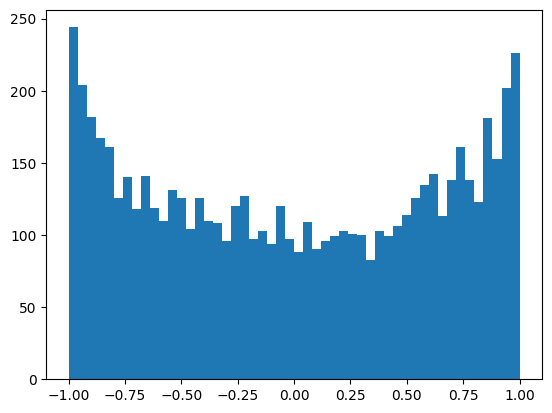

In [103]:
# tanh issue
plt.hist(h.view(-1).tolist(), 50)

(array([  3.,   0.,   0.,   1.,   2.,   5.,   2.,   7.,  11.,  16.,  27.,
         49.,  49.,  81.,  96., 116., 142., 192., 239., 252., 330., 382.,
        422., 469., 440., 432., 392., 381., 386., 314., 277., 197., 173.,
        124., 104.,  89.,  56.,  54.,  27.,  20.,  13.,   4.,  10.,   7.,
          2.,   2.,   1.,   1.,   0.,   1.]),
 array([-4.4272542 , -4.24895014, -4.07064608, -3.89234201, -3.71403795,
        -3.53573389, -3.35742983, -3.17912577, -3.0008217 , -2.82251764,
        -2.64421358, -2.46590952, -2.28760546, -2.1093014 , -1.93099733,
        -1.75269327, -1.57438921, -1.39608515, -1.21778109, -1.03947702,
        -0.86117296, -0.6828689 , -0.50456484, -0.32626078, -0.14795671,
         0.03034735,  0.20865141,  0.38695547,  0.56525953,  0.74356359,
         0.92186766,  1.10017172,  1.27847578,  1.45677984,  1.6350839 ,
         1.81338797,  1.99169203,  2.16999609,  2.34830015,  2.52660421,
         2.70490828,  2.88321234,  3.0615164 ,  3.23982046,  3.41812452,
 

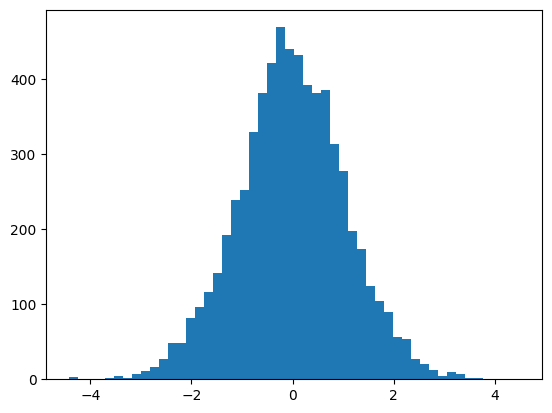

In [104]:
plt.hist(h_pre_act.view(-1).tolist(), 50)

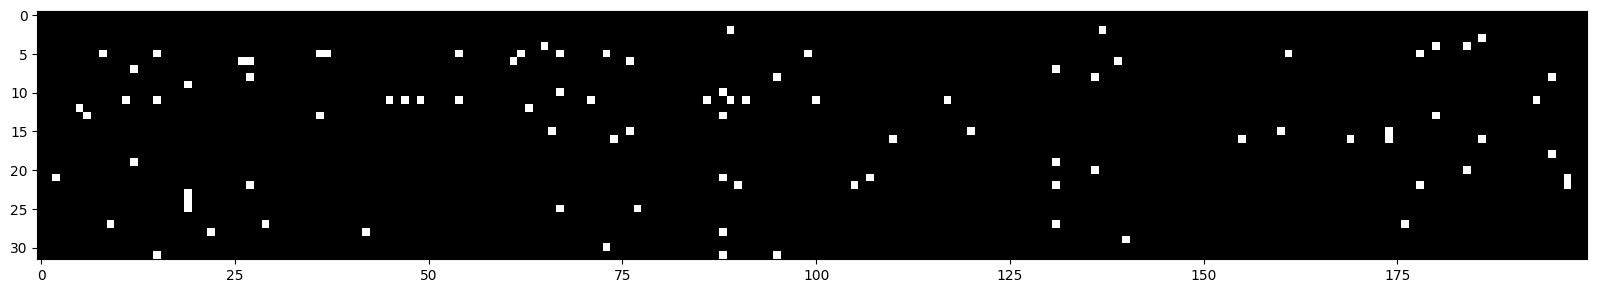

In [105]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

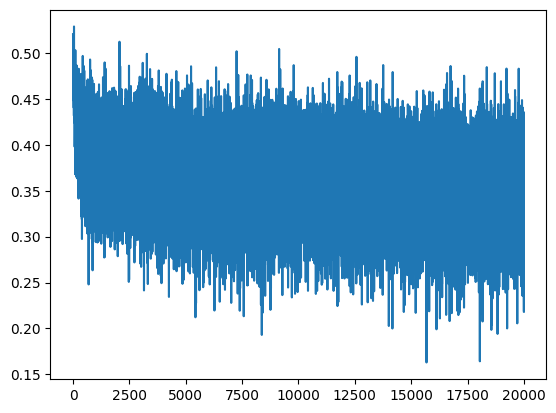

In [106]:
plt.plot(lossi)

In [107]:
@torch.no_grad() # decorator disables gradient tracking - memory efficient coz we dont call backward
def split_loss(split):
    x, y = {
        'train': [Xtr, Ytr],
        'val': [Xdev, Ydev],
        'test': [Xte, Yte],
    }[split]

    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    h_pre_act = embcat @ W1 + b1
    h_pre_act = bngain * (h_pre_act - h_pre_act.mean(0, keepdim=True)) / h_pre_act.std(0, keepdim=True) + bnbias
    h = torch.tanh(h_pre_act)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.2115511894226074
val 2.2284324169158936


In [108]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialise with all

    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break

    print(''.join(i_to_s[i] for i in out)) # decode and print the generated word

carmahza.
brhleigh.
mrix.
luty.
skland.
grrxhnn.
favellhcierenic.
ramsistchailv.
brleggbbhll.
frin.
qhijussrlings.
jadbb.
wruth.
gijaryxigfryskpirrdy.
bdde.
xiz.
gtrffrystry.
huqembud.
husya.
bmbboroz.
